In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import queue

cities = [
    (2066,2333),
    (935,1304),
    (1270,200),
    (1389,700),
    (984,2810),
    (2253,478),
    (949,3025),
    (87,2483),
    (3094,1883),
    (2706,3130),
]
def generate_distance_matrix(cities):
    distance_matrix = []
    def calc_distance(loc1, loc2):
        return np.sqrt((loc1[0] - loc2[0]) ** 2 + (loc1[1] - loc2[1]) ** 2)

    for i in range(len(cities)):
        row = []
        for j in range(len(cities)):
            row.append(calc_distance(cities[i], cities[j]))
        distance_matrix.append(row)
    return np.array(distance_matrix)
distance_matrix = generate_distance_matrix(cities)

In [2]:
from tqdm import tqdm
class Hopfiel_Neural_Network():
    def __init__(self, distance_matrix, A=1.5, D=0.5, U0=0.02, lr=0.05, num_iterations=10000):
        self.distance_matrix = distance_matrix
        assert isinstance(distance_matrix, np.ndarray)
        assert distance_matrix.shape[0] == distance_matrix.shape[1]
        self.A = A
        self.D = D
        self.U0 = U0
        self.lr = lr
        self.num_iterations = num_iterations
        self._city_num = distance_matrix.shape[0]
    
    def _generate_U(self, distance_matrix):
        return 0.5 * self.U0 * np.log(distance_matrix.shape[0] - 1) + 2 * (np.random.random(distance_matrix.shape)) - 1

    def _calc_V(self, U):
        return 0.5 * (1 + np.tanh(U / self.U0))

    def _calc_energy(self, V, distance_matrix):
        e1 = np.sum(np.sum(V, axis=0) ** 2)
        e2 = np.sum(np.sum(V, axis=1) ** 2)
        e3 = np.matmul(distance_matrix, np.hstack([V[:, 1:], V[:, :1]])) * V
        return 0.5 * (self.A * (e1 + e2) + self.D * np.sum(e3))

    def _calc_dU(self, V, distance_matrix):
        du1 = np.tile(np.sum(V, axis=0, keepdims=True) - 1.0, (V.shape[0], 1))
        du2 = np.tile(np.sum(V, axis=1, keepdims=True) - 1.0, (1, V.shape[0]))
        du3 = np.matmul(distance_matrix, np.hstack([V[:, 1:], V[:, :1]]))
        return -(self.A * (du1 + du2) + self.D * du3)

    def _generate_route(self, V):
        res = []
        for i in range(V.shape[0]):
            flag = np.max(V[:, i])
            for j in range(V.shape[0]):
                if V[j, i] == flag:
                    res.append(j)
                    break
        return res

    def _calc_distance(self, route):
        res = 0
        for _ in range(len(route)):
            res += self.distance_matrix[route[_], route[(_ + 1) % len(route)]]
        return res

    def generate_res(self):
        process_dist_matrix = 0.5 * self.distance_matrix / np.max(self.distance_matrix)
        U = self._generate_U(process_dist_matrix)
        V = self._calc_V(U)
        energy = self._calc_energy(V, process_dist_matrix)
        energy_list = [energy]
        distance_list = []
        best_distance = np.Inf
        best_route = None
        for iteration in tqdm(range(self.num_iterations)):
            dU = self._calc_dU(V, process_dist_matrix)
            U += self.lr * dU
            V = self._calc_V(U)
            energy = self._calc_energy(V, process_dist_matrix)
            energy_list.append(energy)
            route = self._generate_route(V)
            if len(np.unique(route)) == len(route):
                distance = self._calc_distance(route)
                distance_list.append(distance)
                if distance < best_distance:
                    best_distance = distance
                    best_route = route
        return best_route, best_distance, energy_list, distance_list

In [3]:
hopfield = Hopfiel_Neural_Network(distance_matrix)
route, distance, energy_list, distance_list = hopfield.generate_res()

100%|██████████| 10000/10000 [00:01<00:00, 7202.64it/s]


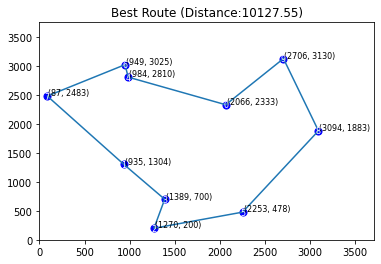

In [36]:
def show_route(cities, route, distance):
    plt.figure()
    max_x = 0
    max_y = 0
    for idx in range(len(cities)):
        city = cities[idx]
        max_x = max(max_x, city[0])
        max_y = max(max_y, city[1])
        plt.scatter(city[0], city[1], color='blue', s=50)
        plt.text(x=city[0] + 10, y=city[1] + 10, s="({}, {})".format(city[0], city[1]), fontsize=8)
        plt.text(x=city[0] - 30, y=city[1] - 45, s=idx, fontsize=8, color='white')
    plt_x = []
    plt_y = []
    for idx in route:
        plt_x.append(cities[idx][0])
        plt_y.append(cities[idx][1])
    plt_x.append(plt_x[0])
    plt_y.append(plt_y[0])
    plt.plot(plt_x, plt_y)
    plt.title("Best Route (Distance:{})".format(distance))
    plt.xlim(0, 1.2 * max_x)
    plt.ylim(0, 1.2 * max_y)
show_route(cities, route, round(distance, 2))

Text(0.5, 0, 'Iteration')

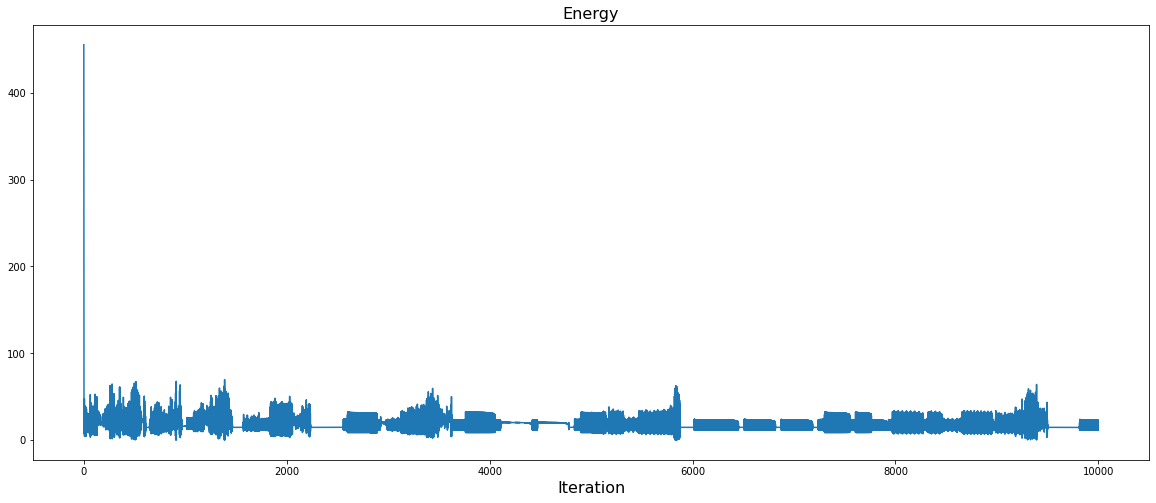

In [37]:
plt.figure(figsize=(20, 8))
plt.plot(energy_list)
plt.title("Energy", fontsize=16)
plt.xlabel("Iteration", fontsize=16)

Text(0.5, 0, 'Iteration')

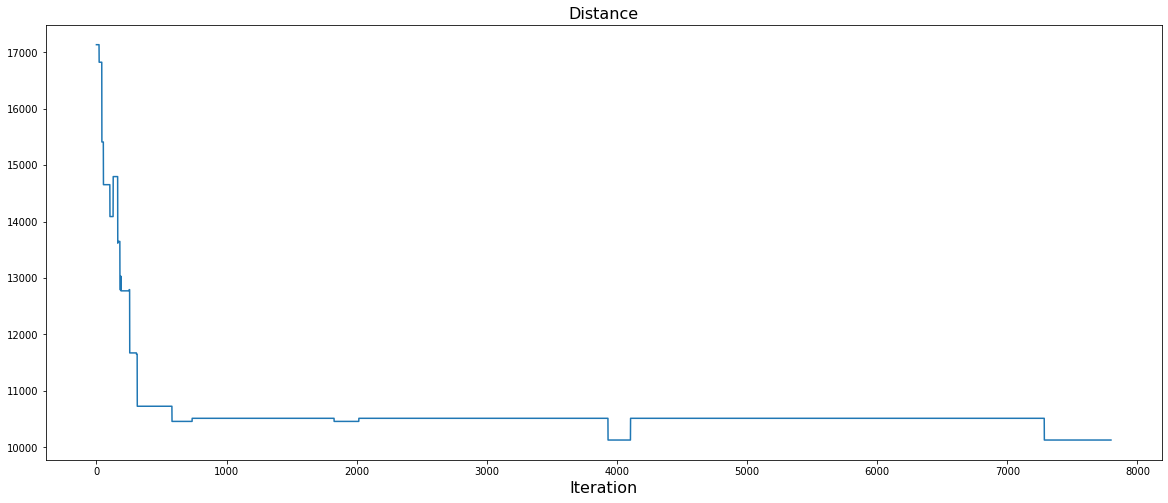

In [38]:
plt.figure(figsize=(20, 8))
plt.plot(distance_list)
plt.title("Distance", fontsize=16)
plt.xlabel("Iteration", fontsize=16)

In [8]:
# 使用回溯法对Hopfield的结果进行检验
class Node:
    def __init__(self, path=None, cost=None):
        self.path = path
        self.cost = cost

def verified(distance_matrix):
    matrix = distance_matrix
    vnum = distance_matrix.shape[0]

    best_cost = np.inf    
    best_path = None

    start = Node(path=[1], cost=0)  
    TSP_Queue = queue.LifoQueue()
    TSP_Queue.put(start)  

    while not TSP_Queue.empty():
        cur_node = TSP_Queue.get()

        if cur_node.cost > best_cost:
            continue

        if len(cur_node.path) == vnum:
            new_cost = cur_node.cost + matrix[cur_node.path[-1] - 1, 0]  
            if new_cost < best_cost:
                best_cost = new_cost
                best_path = list(cur_node.path)
            continue

        for i in range(vnum, 0, -1):
            if not (i in cur_node.path):
                new_cost = cur_node.cost + matrix[cur_node.path[-1] - 1, i - 1]  
                if new_cost < best_cost:
                    new_path = list(cur_node.path)
                    new_path.append(i)
                    new_node = Node(path=new_path, cost=new_cost)
                    TSP_Queue.put(new_node)
    return round(best_cost, 2), list(map(lambda x: x - 1, best_path))

best_cost, best_path = verified(distance_matrix)
print("Best Cost: {} Best Path: {}".format(best_cost, best_path))

Best Cost: 10127.55 Best Path: [0, 4, 6, 7, 1, 3, 2, 5, 8, 9]


In [23]:
# 随机生成
def random_cities(n):
    res = []
    for _ in range(n):
        res.append((np.random.randint(0, 10000), np.random.randint(0, 10000)))
    return res

In [24]:
random_distance_matrix = generate_distance_matrix(random_cities(10))
hopfield = Hopfiel_Neural_Network(random_distance_matrix)
hop_route, hop_distance, hop_energy_list, hop_distance_list = hopfield.generate_res()
verified_cost, verified_path = verified(random_distance_matrix)
print("Best Cost: {} Best Path: {}".format(round(hop_distance, 2), hop_route))
print("Best Cost: {} Best Path: {}".format(verified_cost, verified_path))

100%|██████████| 10000/10000 [00:01<00:00, 8073.34it/s]


Best Cost: 29468.77 Best Path: [1, 0, 4, 3, 8, 5, 6, 2, 7, 9]
Best Cost: 29468.77 Best Path: [0, 1, 9, 7, 2, 6, 5, 8, 3, 4]


In [35]:
random_distance_matrix = generate_distance_matrix(random_cities(12))
hopfield = Hopfiel_Neural_Network(random_distance_matrix)
hop_route, hop_distance, hop_energy_list, hop_distance_list = hopfield.generate_res()
verified_cost, verified_path = verified(random_distance_matrix)
print("Best Cost: {} Best Path: {}".format(round(hop_distance, 2), hop_route))
print("Best Cost: {} Best Path: {}".format(verified_cost, verified_path))

100%|██████████| 10000/10000 [00:01<00:00, 7369.96it/s]


Best Cost: 34926.47 Best Path: [4, 1, 11, 0, 8, 6, 10, 7, 2, 9, 3, 5]
Best Cost: 34258.0 Best Path: [0, 6, 8, 10, 7, 2, 9, 3, 5, 4, 1, 11]
